* [1.Fonctions utilisateurs](#fc)
* [2.Description des données](#dd)
* [3.Clustering](#clus)
  * [3.1.Kmeans(RFM)](#kmeans1)
  * [3.2.Kmeans(RFM+review_score)](#kmeans2)
  * [3.3.DBSCAN(RFM)](#db)
  * [3.4.Agglomerative clustering(RFM)](#ag)
  * [3.5.Kprototypes(RFM+favorite_purshase_month)](#kp)
* [4.Stabilité temporelle de la segmentation:kmeans(RFM)](#st)


In [3]:
#!pip install yellowbrick
#!pip install kmodes

#!pip install autopep8
#!pip install jupyter_contrib_nbextensions


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
import time
import os
import missingno as msno
import numpy as np
import pandas as pd
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import DBSCAN

%matplotlib inline

In [5]:
os.getcwd()
#os.chdir('C:\\Users\\IMEN\\Documents\\openclassroom\\formation openclassrooms\\projet5')

'C:\\Users\\imen2\\OneDrive\\Documents\\Openclassrooms\\formation_OC\\projet5'

## 1. Fonctions utilisateurs <a class="anchor" id="fc"></a>

In [6]:
def felbow_kprototypes(k_rng, data, index_categ_feat):
    # Elbow technique
    cost = []
    for cluster in k_rng:
        print('{cluster}\.cluster start'.format(cluster=cluster))
        kproto = KPrototypes(n_clusters=cluster, init='Huang',
                             n_jobs=-1, n_init=10, verbose=1)
        kproto.fit(data, categorical=[index_categ_feat])
        cost.append(kproto.cost_)

    plt.plot(k_rng, cost)
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost')

In [7]:
def felbow(k_rng, data):
    # Elbow technique
    wcss = []
    for i in k_rng:
        model = KMeans(n_clusters=i, init='k-means++', random_state=42)
        model.fit(data)
        wcss.append(model.inertia_)
    plt.plot(k_rng, wcss)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')

In [8]:
def fsilhouette(k_rng, data):
    # Silhouette technique
    sse_ = []
    for k in k_rng:
        kmeans = KMeans(n_clusters=k, init='k-means++',
                        random_state=42).fit(data)
        sse_.append([k, silhouette_score(data, kmeans.labels_)])
    plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])

In [9]:
def mean_clus_feat(df, group, feat):
    df_mean = pd.DataFrame(df.groupby(group)[feat].mean()).rename(
        columns={feat: feat+'_mean'})
    return df_mean

In [10]:
def fnb_customper_cluster(df):
    customer_per_cluster = pd.DataFrame(df.groupby('ClusterID')['CustomerID'].count())\
        .rename(columns={'CustomerID': 'nb_customers'}).reset_index()
    return (customer_per_cluster)

In [11]:
def fpairplot(df, lists, title):
    fig = plt.figure(constrained_layout=True, figsize=(20, 5))

    gs = GridSpec(1, 3, figure=fig)
    #"Recency", "Frequency", "Monetary"
    #lists=[["Recency", "Frequency"],["Recency","Monetary"],["Frequency","Monetary"]]
    i = 0
    for c in lists:
        plt.subplot(gs[0, i])
        sns.scatterplot(data=df, x=c[0], y=c[1]).set(title=title)
        i = i+1

## 2.Description des données<a class="anchor" id="dd"></a>

In [12]:
df_cmd = pd.read_csv('commandes_dataset.csv')
df_geo = pd.read_csv('geolocalisation_dataset.csv')
# RFM=pd.read_csv('df_rfm.csv')
RFM_date = pd.read_csv('df_rfm_date.csv')


In [13]:
RFM_date.columns

Index(['customer_unique_id', 'Frequency', 'Recency', 'Monetary',
       'last_purshase_date', 'favorite_purshase_month'],
      dtype='object')

In [14]:
df_cmd['order_purchase_timestamp']=pd.to_datetime(df_cmd['order_purchase_timestamp'])

In [15]:
RFM = RFM_date[['customer_unique_id', 'Frequency', 'Recency', 'Monetary']]
RFM

,customer_unique_id,Frequency,Recency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90
2,0000f46a3911fa3c0805444483337064,1,537,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00
...,...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,447,1570.00
91474,fffea47cd6d3cc0a88bd621562a9d061,1,262,64.89
91475,ffff371b4d645b6ecea244b27531430a,1,568,89.90
91476,ffff5962728ec6157033ef9805bacc48,1,119,115.00


In [16]:
RFM.isna().sum()

customer_unique_id    0
Frequency             0
Recency               0
Monetary              0
dtype: int64

In [17]:
df_cmd.isna().sum()

customer_id                 0
customer_unique_id          0
customer_city               0
customer_state              0
order_id                    0
order_status                0
order_purchase_timestamp    0
order_item_id               0
product_id                  0
seller_id                   0
price                       0
payment_type                0
review_id                   0
review_score                0
product_category_name       0
seller_zip_code_prefix      0
seller_city                 0
seller_state                0
dtype: int64

## 3.Clustering <a class="anchor" id="clus"></a>

### 3.1.Kmeans (RFM)<a class="anchor" id="kmeans1"></a>

In [18]:
X = RFM[['Frequency', 'Recency', 'Monetary']]
# Scaling input using StandardScaler

scaler = StandardScaler()
Xstd = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [19]:
Xstd.describe()

,Frequency,Recency,Monetary
count,9.147800e+04,9.147800e+04,9.147800e+04
mean,9.439287e-17,-2.268070e-17,-1.222583e-16
std,1.000005e+00,1.000005e+00,1.000005e+00
min,-3.115796e-01,-1.547248e+00,-6.520442e-01
25%,-3.115796e-01,-8.065545e-01,-4.346193e-01
50%,-3.115796e-01,-1.248539e-01,-2.490954e-01
75%,-3.115796e-01,7.076075e-01,6.358022e-02
max,3.353783e+01,3.001792e+00,6.015974e+01


In [20]:
k_rng = range(2, 11)

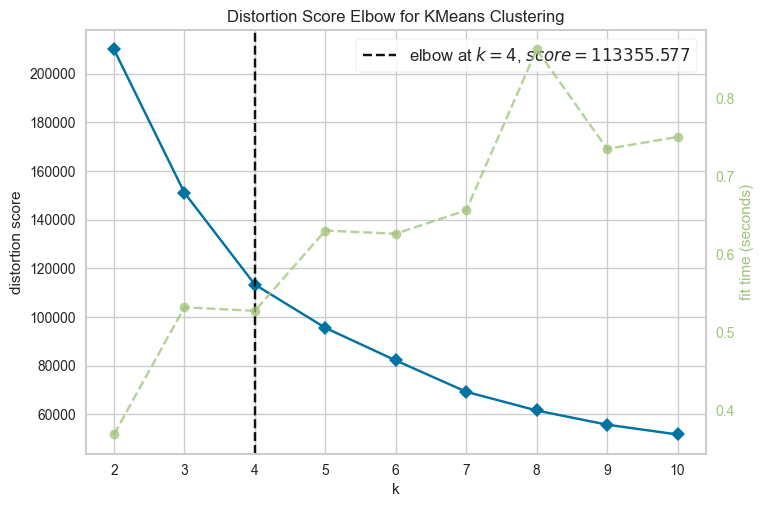

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=k_rng)

visualizer.fit(Xstd)    # Fit the data to the visualizer
visualizer.poof()

In [22]:
bestk = visualizer.elbow_value_
bestk

4

**Remarque**<br>
-le silhouette score est entre - et 1<br>
-score proche de 1==>les points du meme cluster sont très similaire<br>
-score proche de -1==>les points du meme cluster ne sont très similaire


In [58]:
# Instantiate the clustering model and visualizer
# %matplotlib notebook

# visualizer = SilhouetteVisualizer(KMeans(7))

# visualizer.fit(Xstd)    # Fit the data to the visualizer
# visualizer.poof()

<IPython.core.display.Javascript object>


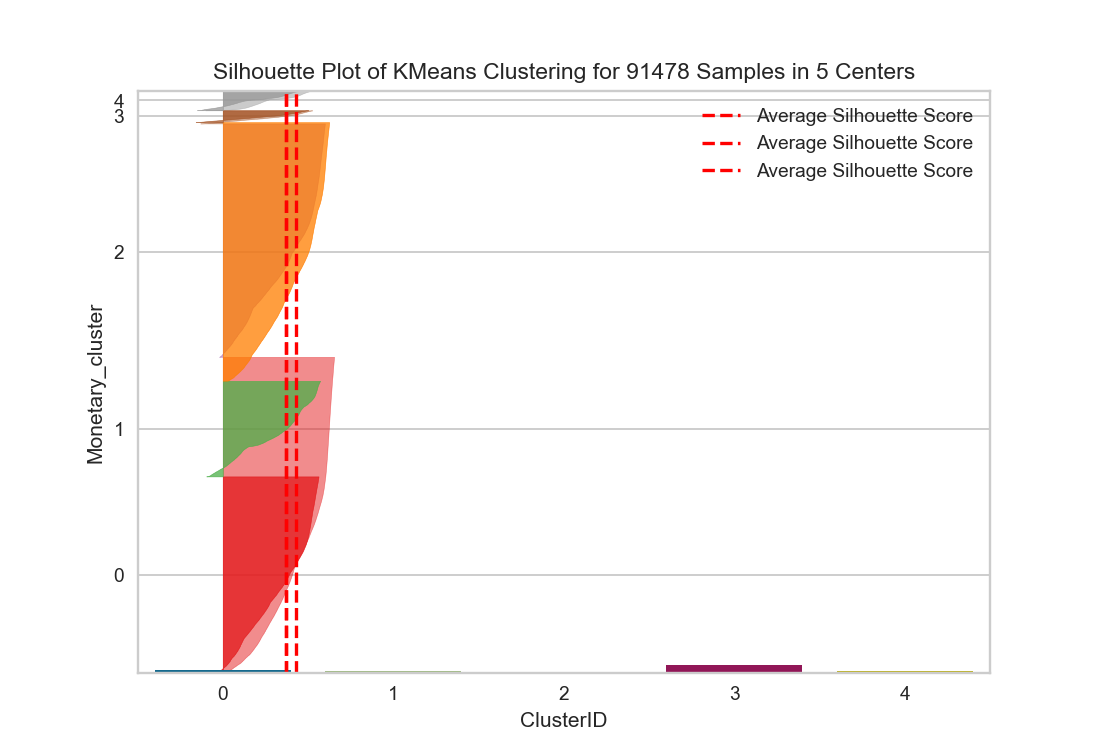

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 91478 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [59]:
# Instantiate the clustering model and visualizer
%matplotlib notebook
model2 = KMeans(4,init='k-means++',random_state=42)
visualizer2 = SilhouetteVisualizer(model2)

visualizer2.fit(Xstd)    # Fit the data to the visualizer
visualizer2.poof()

In [25]:
# pour k=4
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42)
y_kmeans = kmeans.fit_predict(Xstd)
y_kmeans

array([0, 0, 1, ..., 1, 0, 1])

In [57]:
k_selected=4
silhouette_avg = silhouette_score(Xstd, y_kmeans)
print("For n_clusters =",
        k_selected,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 4 The average silhouette_score is : 0.43179645876872036


For n_clusters = 4 The average silhouette_score is : 0.43179645876872036

In [ ]:
RFM.shape

In [28]:
RFM_km = pd.concat([RFM, pd.Series(y_kmeans)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency',
                  'Recency', 'Monetary', 'ClusterID']
RFM_km

,CustomerID,Frequency,Recency,Monetary,ClusterID
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90,0
2,0000f46a3911fa3c0805444483337064,1,537,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00,1
...,...,...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,447,1570.00,2
91474,fffea47cd6d3cc0a88bd621562a9d061,1,262,64.89,1
91475,ffff371b4d645b6ecea244b27531430a,1,568,89.90,1
91476,ffff5962728ec6157033ef9805bacc48,1,119,115.00,0


In [29]:
customer_per_cluster1 = fnb_customper_cluster(RFM_km)
customer_per_cluster1

,ClusterID,nb_customers
0,0,49657
1,1,36679
2,2,2053
3,3,3089


**Obserrvations**<br>
le cluster 1 contient le plus de clients
    

In [30]:
RFM_km.describe()

,Frequency,Recency,Monetary,ClusterID
count,91478.000000,91478.000000,91478.000000,91478.000000
mean,1.211712,237.047662,144.949038,0.547148
std,0.679484,152.560470,220.997009,0.703757
min,1.000000,1.000000,0.850000,0.000000
25%,1.000000,114.000000,48.900000,0.000000
50%,1.000000,218.000000,89.900000,0.000000
75%,1.000000,345.000000,159.000000,1.000000
max,24.000000,695.000000,13440.000000,3.000000


<AxesSubplot: title={'center': 'Recency'}, xlabel='ClusterID'>

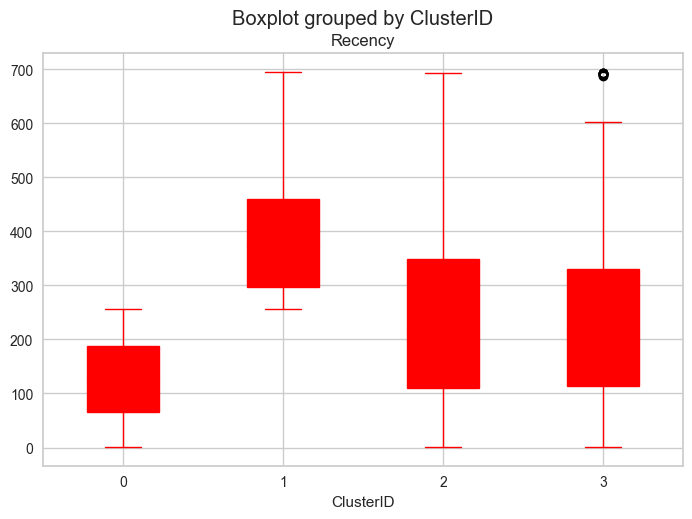

In [34]:
RFM_km.boxplot(column='Recency', by='ClusterID', color='red',patch_artist = True)

**Observations**<br>
Pour la récence, que le cluster 0 contient des outliers.<br>
cluster0:client les plus récents<br>
cluster1:clients les moins récents.ça fait longtemps qu'ils ont commandés.

<AxesSubplot: title={'center': 'Monetary'}, xlabel='ClusterID'>

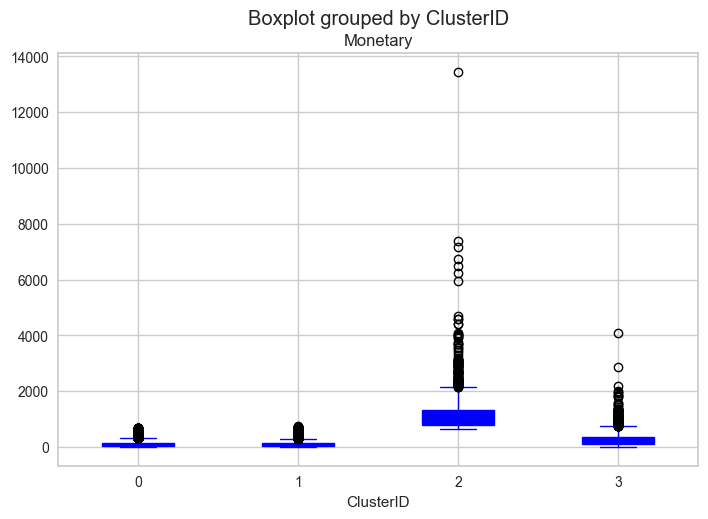

In [36]:
RFM_km.boxplot(column='Monetary', by='ClusterID', color='blue',patch_artist = True)

**Observations**<br>
Pour les montants,le troisieme cluster(2) ont les montants les plus élevés. 

<AxesSubplot: title={'center': 'Frequency'}, xlabel='ClusterID'>

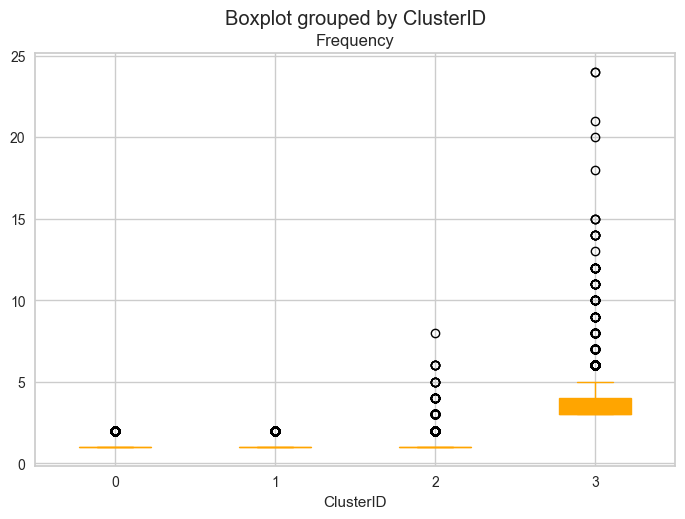

In [38]:
RFM_km.boxplot(column='Frequency', by='ClusterID',color='orange',patch_artist = True)

In [27]:
RFM_km[RFM_km.ClusterID == 2]['Frequency'].unique()

array([1, 2, 3, 6, 8, 4, 5], dtype=int64)

**Observations**<br>
-le cluster 0 contient que les clienst qui ont achétes peu de fois (1,2)<br>
-le cluster 1 contient que les clienst qui ont achétes peu de fois (1,2)<br>
-le cluster 2 contient que les clienst qui ont achétes peu de fois (1, 2, 3, 6, 8, 4, 5)<br>
-le cluster 3 contient que les clienst qui ont achétes entre 4 et 24 fois <br>

In [28]:
cluster0 = RFM_km[RFM_km.ClusterID == 0]
cluster1 = RFM_km[RFM_km.ClusterID == 1]
cluster2 = RFM_km[RFM_km.ClusterID == 2]
cluster3 = RFM_km[RFM_km.ClusterID == 3]

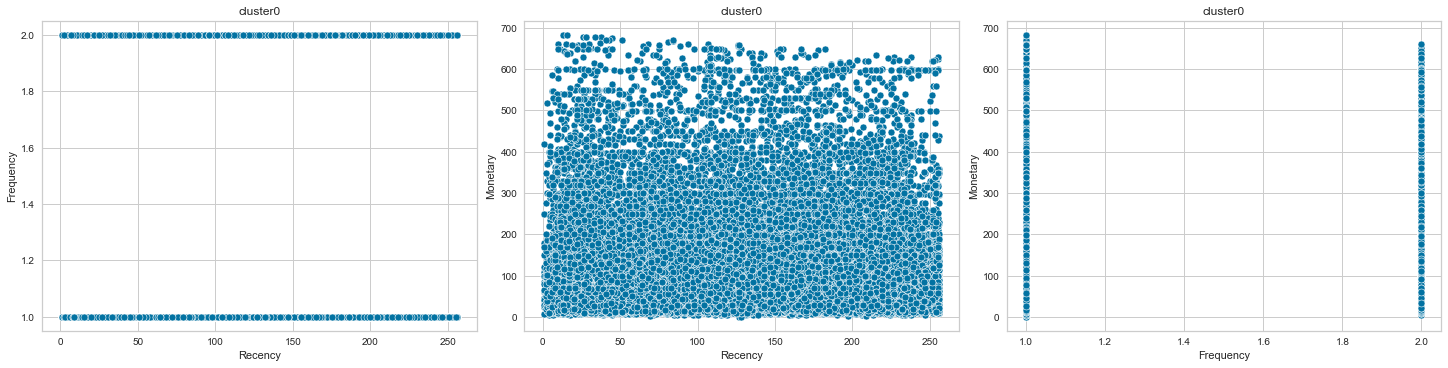

In [29]:
lists = [["Recency", "Frequency"], [
    "Recency", "Monetary"], ["Frequency", "Monetary"]]
fpairplot(cluster0, lists, 'cluster0')

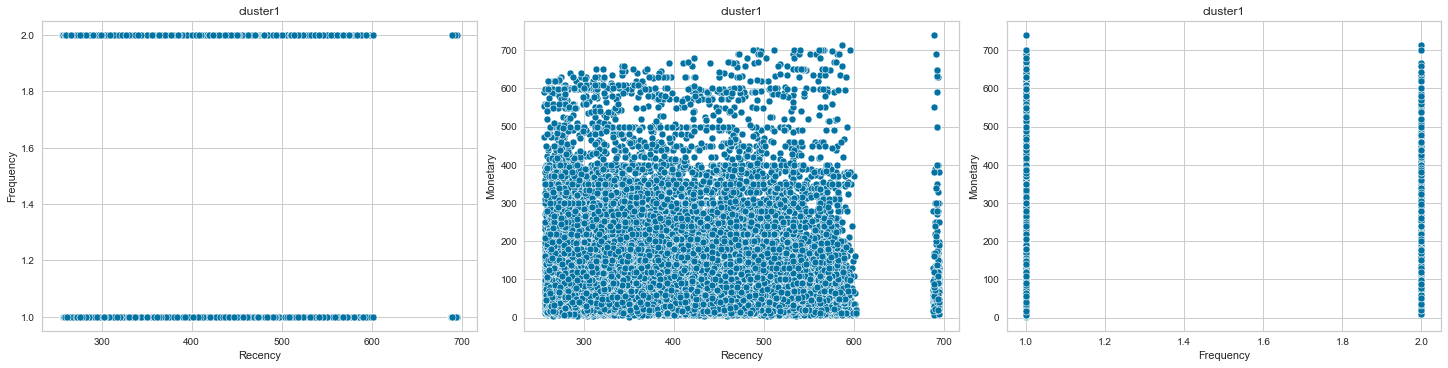

In [30]:
lists = [["Recency", "Frequency"], [
    "Recency", "Monetary"], ["Frequency", "Monetary"]]
fpairplot(cluster1, lists, 'cluster1')

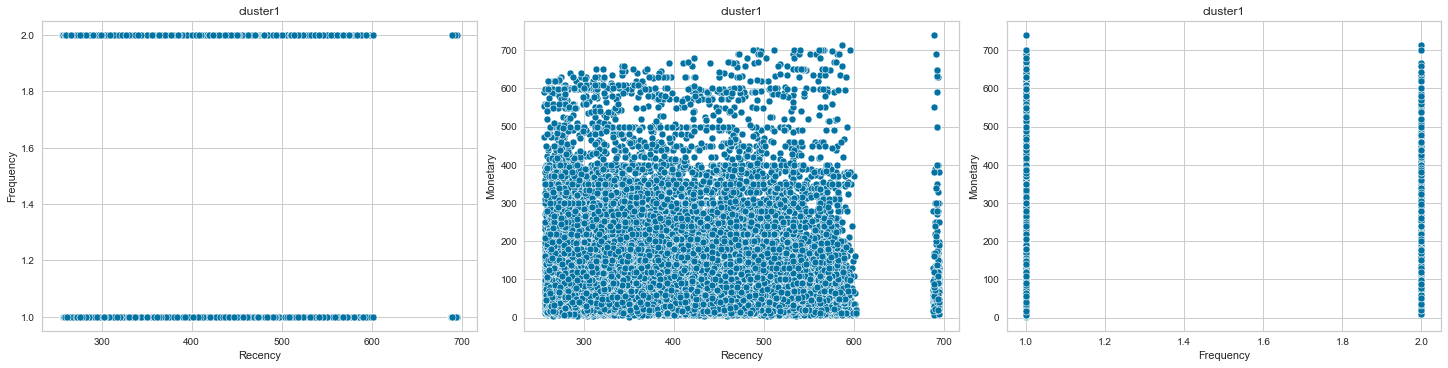

In [31]:
lists = [["Recency", "Frequency"], [
    "Recency", "Monetary"], ["Frequency", "Monetary"]]
fpairplot(cluster1, lists, 'cluster1')

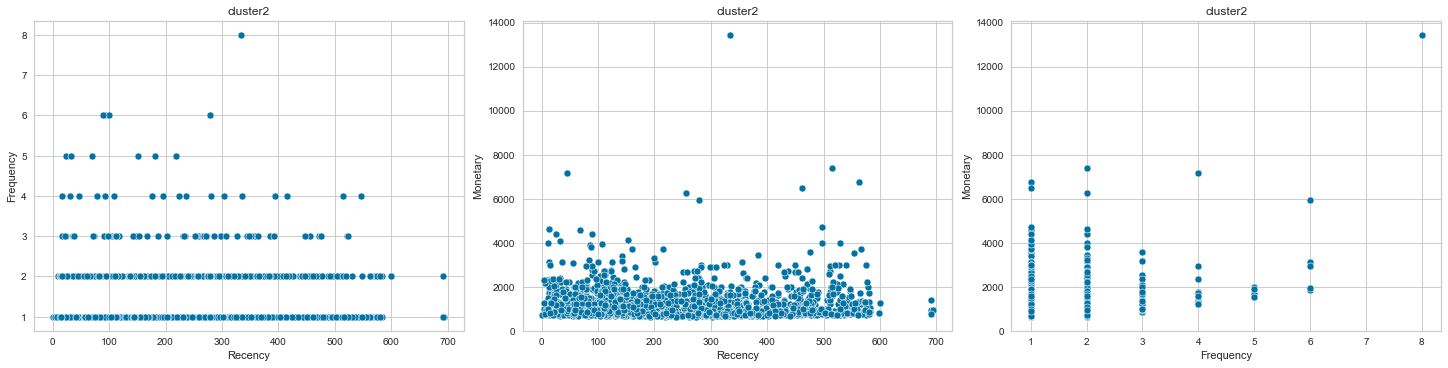

In [32]:
lists = [["Recency", "Frequency"], [
    "Recency", "Monetary"], ["Frequency", "Monetary"]]
fpairplot(cluster2, lists, 'cluster2')

In [96]:
lists = [["Recency", "Frequency"], [
    "Recency", "Monetary"], ["Frequency", "Monetary"]]
fpairplot(cluster3, lists, 'cluster3')

NameError: name 'cluster3' is not defined

In [ ]:
data = RFM_km[['ClusterID', 'Frequency',  'Recency', 'Monetary']]
sns.pairplot(data, hue='ClusterID', diag_kind="hist",
             palette=sns.color_palette(n_colors=4))

**Observations**<br>

In [39]:
km_recency_clusters = mean_clus_feat(RFM_km, 'ClusterID', 'Recency')
km_frequency_clusters = mean_clus_feat(RFM_km, 'ClusterID', 'Frequency')
km_monetary_clusters = mean_clus_feat(RFM_km, 'ClusterID', 'Monetary')

In [ ]:
km_recency_clusters

In [ ]:
km_frequency_clusters

In [ ]:
km_monetary_clusters

In [41]:
df = pd.concat([pd.Series([0, 1, 2, 3]), km_recency_clusters,
               km_frequency_clusters, km_monetary_clusters], axis=1)
df.columns = ["ClusterID", "Recency_mean", "Frequency_mean", "Monetary_mean"]

In [42]:
df

,ClusterID,Recency_mean,Frequency_mean,Monetary_mean
0,0,126.984071,1.111263,114.837330
1,1,386.399029,1.113525,115.746640
2,2,236.316610,1.263030,1178.096069
3,3,233.444480,3.958239,289.112522


**Observations**<br>
-La moyenne de la récence du troisieme cluster est le plus proche de la moyenne de la récence globale(237à peu près). <br>



<AxesSubplot: xlabel='ClusterID', ylabel='Recency_mean'>

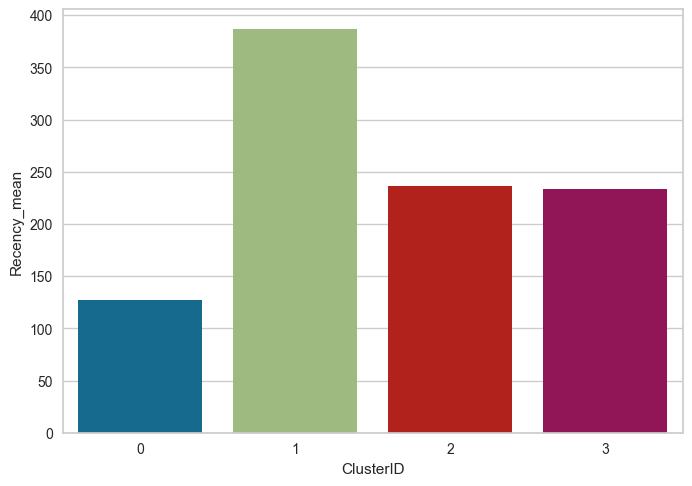

In [43]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

**Observations**<br>
Les clients du cluster(cluster0) sont les clients qui ont les commandes les plus récentes<br>
Les clients du cluster(cluster1) sont les clients qui ont les commandes les plus anciennes

<AxesSubplot: xlabel='ClusterID', ylabel='Frequency_mean'>

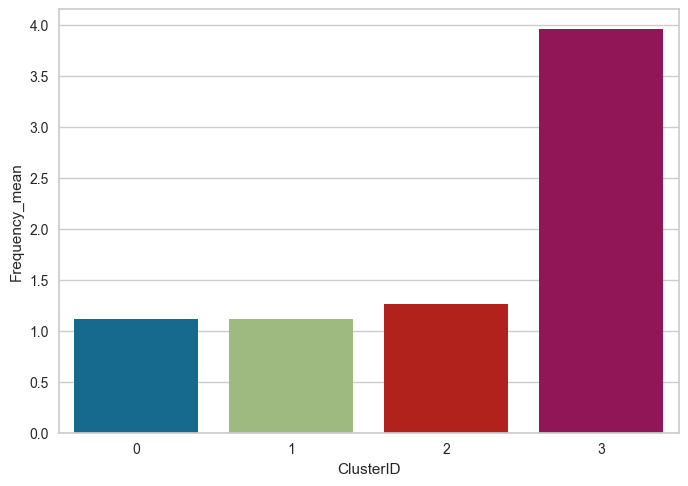

In [44]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

**Observations**<br>
Les clients du cluster 4 (cluster3) sont les clients qui ont effectuées plusieurs commandes

<AxesSubplot: xlabel='ClusterID', ylabel='Monetary_mean'>

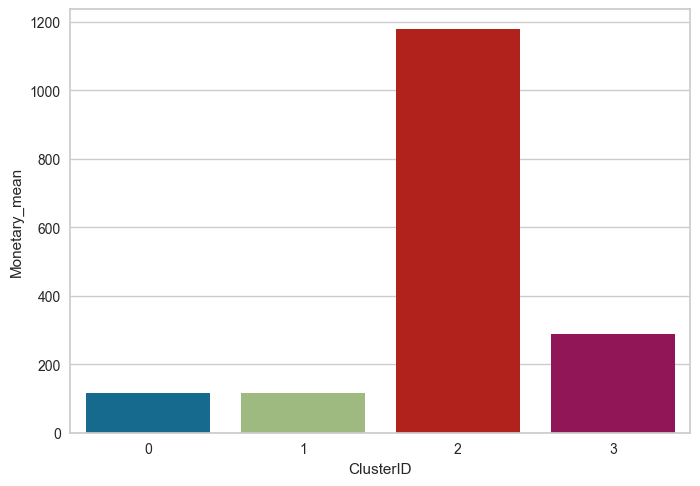

In [45]:
sns.barplot(x=df.ClusterID, y=df.Monetary_mean)

**Observations**<br>
Les clients du 3ème cluster(cluster 2) sont les clients qui ont payés le plus.
<br>


**Conclusion**<br>
2.le 1er cluster(cluster 0):clients avec des montants faibles,fréquences faibles et récence faible<br>
2.le 2ème cluster(cluster 1):clients avec des commandes récentes<br>
2.le 3ème cluster(cluster 2):clients avec des montants faibles.<br>
1.le 4ème cluster(cluster 3): clients avec des montants élevés .<br>


#### Qualification des clusters

In [47]:
customer_types = ['nouveau  client', ' client perdu',
                  'meilleur client', 'client risquant de partir']
rfm_caracte = ['client  avec faible fréquence et faibles dépenses et ça fait longtemps qu\'il n\'a pas passé de commandes',
               'client récent avec faible fréquence et dépenses',
               'client fréquent et plus au moins récent avec des dépenses importantes',
               'client avec faible  dépenses  et ça fait longtemps qu\'il n\'a pas passé de commandes'
               ]
d = {'Cluster': list(range(0, 4)), 'Type de client': customer_types,
     'Caractéristiques RFM': rfm_caracte}

pd.set_option("display.max_colwidth", None,
              'display.colheader_justify', 'center')
res1 = pd.DataFrame(d)

res1

,Cluster,Type de client,Caractéristiques RFM
0,0,nouveau client,client avec faible fréquence et faibles dépenses et ça fait longtemps qu'il n'a pas passé de commandes
1,1,client perdu,client récent avec faible fréquence et dépenses
2,2,meilleur client,client fréquent et plus au moins récent avec des dépenses importantes
3,3,client risquant de partir,client avec faible dépenses et ça fait longtemps qu'il n'a pas passé de commandes


### 3.2.Kmeans (RFM+review_score)<a class="anchor" id="kmeans2"></a>

<AxesSubplot: >

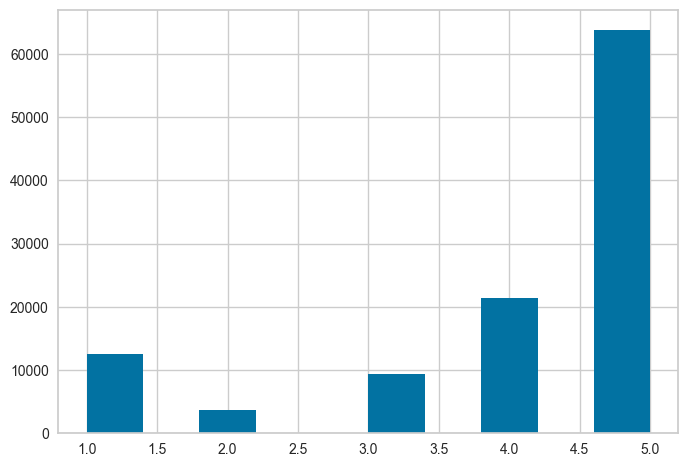

In [48]:
df_cmd['review_score'].hist()

**Observations**<br>
La plupart  desscores sont entre 4.6 et 5 

In [49]:
# scores_review_customers=df_cmd[['customer_unique_id','review_score']]
scores_review_customers = pd.DataFrame(df_cmd.groupby('customer_unique_id')['review_score'].mean())\
    .rename(columns={'review_score': 'review_score_mean'}).reset_index()
scores_review_customers.head()

,customer_unique_id,review_score_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
2,0000f46a3911fa3c0805444483337064,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0
4,0004aac84e0df4da2b147fca70cf8255,5.0


In [ ]:
scores_review_customers.shape

<AxesSubplot: >

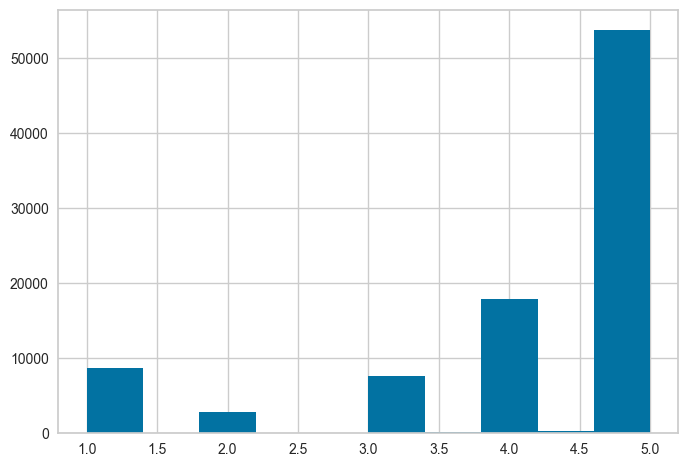

In [50]:
scores_review_customers['review_score_mean'].hist()

In [ ]:
RFM.shape

In [52]:
RFM_score_review = pd.merge(
    RFM, scores_review_customers, on='customer_unique_id')
RFM_score_review.head()

,customer_unique_id,Frequency,Recency,Monetary,review_score_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90,4.0
2,0000f46a3911fa3c0805444483337064,1,537,69.00,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99,4.0
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00,5.0


In [ ]:
RFM_score_review.shape

In [54]:
X1 = RFM_score_review[['Frequency', 'Recency',
                       'Monetary', 'review_score_mean']]
Xstd1 = pd.DataFrame(scaler.fit_transform(X1), columns=X1.columns)

In [55]:
k_rng = range(2, 11)

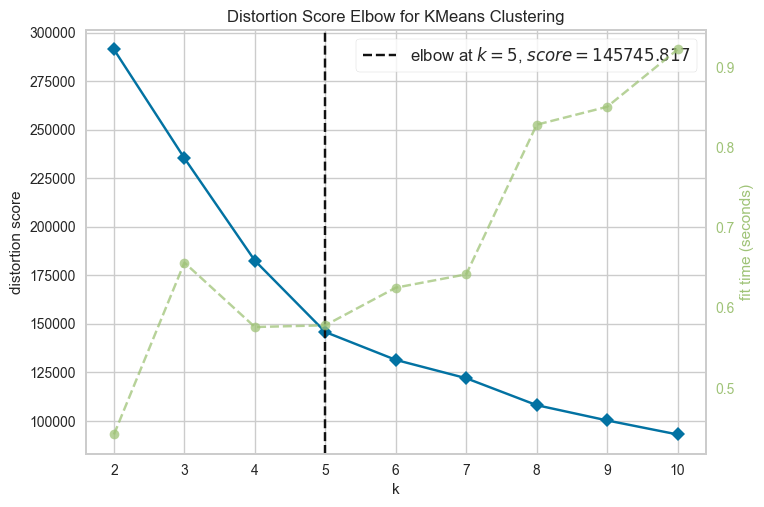

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:

visualizer = KElbowVisualizer(
    KMeans(init='k-means++', random_state=42), k=k_rng)

visualizer.fit(Xstd1)    # Fit the data to the visualizer
visualizer.poof()

In [61]:
visualizer3 = SilhouetteVisualizer(KMeans(5,init='k-means++',random_state=42))
visualizer3.fit(Xstd1)    # Fit the data to the visualizer
visualizer3.poof()

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 91478 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [62]:
kmeans1 = KMeans(n_clusters=5, init="k-means++", random_state=42)
y_kmeans1 = kmeans1.fit_predict(Xstd1)
y_kmeans1

array([2, 2, 0, ..., 0, 2, 0])

In [63]:
k_selected1=5
silhouette_avg1 = silhouette_score(Xstd1, y_kmeans1)
print("For n_clusters =",
        k_selected1,
        "The average silhouette_score is :",
        silhouette_avg1,
    )

For n_clusters = 5 The average silhouette_score is : 0.37248587628602475


In [64]:
RFMS_km = pd.concat([RFM_score_review, pd.Series(y_kmeans1)], axis=1)
RFMS_km.columns = ['CustomerID', 'Frequency',  'Recency',
                   'Monetary', 'review_score_mean', 'ClusterID']
RFMS_km

,CustomerID,Frequency,Recency,Monetary,review_score_mean,ClusterID
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90,5.0,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90,4.0,2
2,0000f46a3911fa3c0805444483337064,1,537,69.00,3.0,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99,4.0,0
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00,5.0,0
...,...,...,...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,447,1570.00,5.0,3
91474,fffea47cd6d3cc0a88bd621562a9d061,1,262,64.89,4.0,0
91475,ffff371b4d645b6ecea244b27531430a,1,568,89.90,5.0,0
91476,ffff5962728ec6157033ef9805bacc48,1,119,115.00,5.0,2


In [65]:
cust_per_clust = fnb_customper_cluster(RFMS_km)
cust_per_clust

,ClusterID,nb_customers
0,0,30863
1,1,15002
2,2,40660
3,3,1863
4,4,3090


**Observations**<br>
le cluster 3 contient le moins de clients<br>
le cluster 2 contient le plus de clients

In [66]:
km1_recency_clusters = mean_clus_feat(RFMS_km, 'ClusterID', 'Recency')
km1_frequency_clusters = mean_clus_feat(RFMS_km, 'ClusterID', 'Frequency')
km1_monetary_clusters = mean_clus_feat(RFMS_km, 'ClusterID', 'Monetary')
km1_score_clusters = mean_clus_feat(RFMS_km, 'ClusterID', 'review_score_mean')

In [70]:
df1 = pd.concat([pd.Series([0, 1, 2, 3, 4]), km1_recency_clusters,
                km1_frequency_clusters, km1_monetary_clusters, km1_score_clusters], axis=1)
df1.columns = ["ClusterID", "Recency_cluster",
               "Frequency_cluster", "Monetary_cluster", "scores_cluster"]
df1

,ClusterID,Recency_cluster,Frequency_cluster,Monetary_cluster,scores_cluster
0,0,392.591874,1.103166,116.014391,4.641739
1,1,229.701440,1.172244,124.686988,1.760432
2,2,122.124127,1.097418,113.781130,4.705903
3,3,234.043478,1.267311,1226.857654,4.162399
4,4,233.175405,3.957929,290.150544,3.654631


In [ ]:
RFMS_km.describe()

<IPython.core.display.Javascript object>


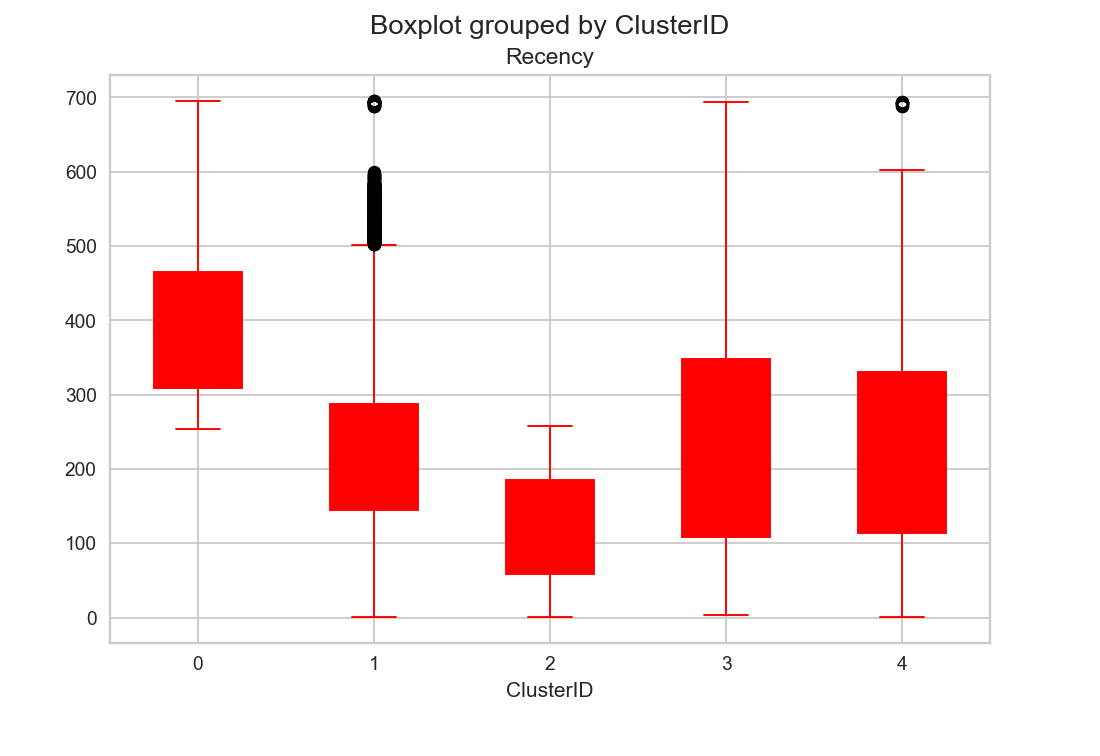

<AxesSubplot: title={'center': 'Recency'}, xlabel='ClusterID'>

In [80]:
RFMS_km.boxplot(column='Recency', by='ClusterID', color='red',patch_artist = True)

<IPython.core.display.Javascript object>


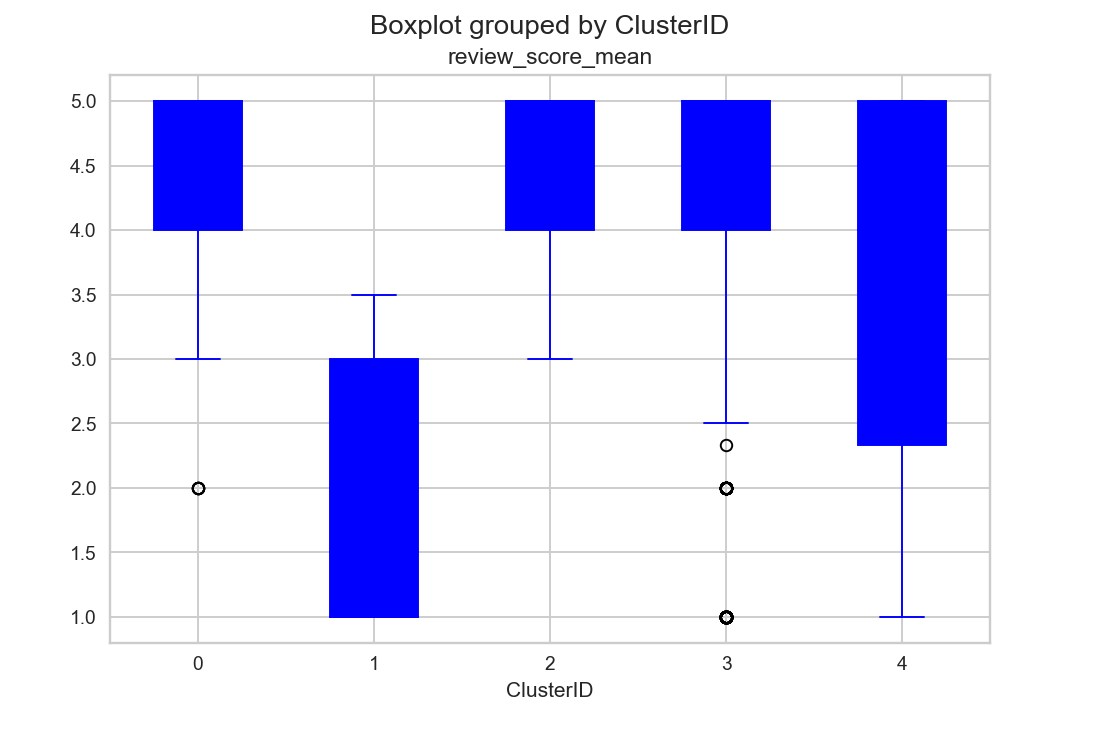

<AxesSubplot: title={'center': 'review_score_mean'}, xlabel='ClusterID'>

In [81]:
RFMS_km.boxplot(column='review_score_mean', by='ClusterID', color='blue',patch_artist = True)

<IPython.core.display.Javascript object>


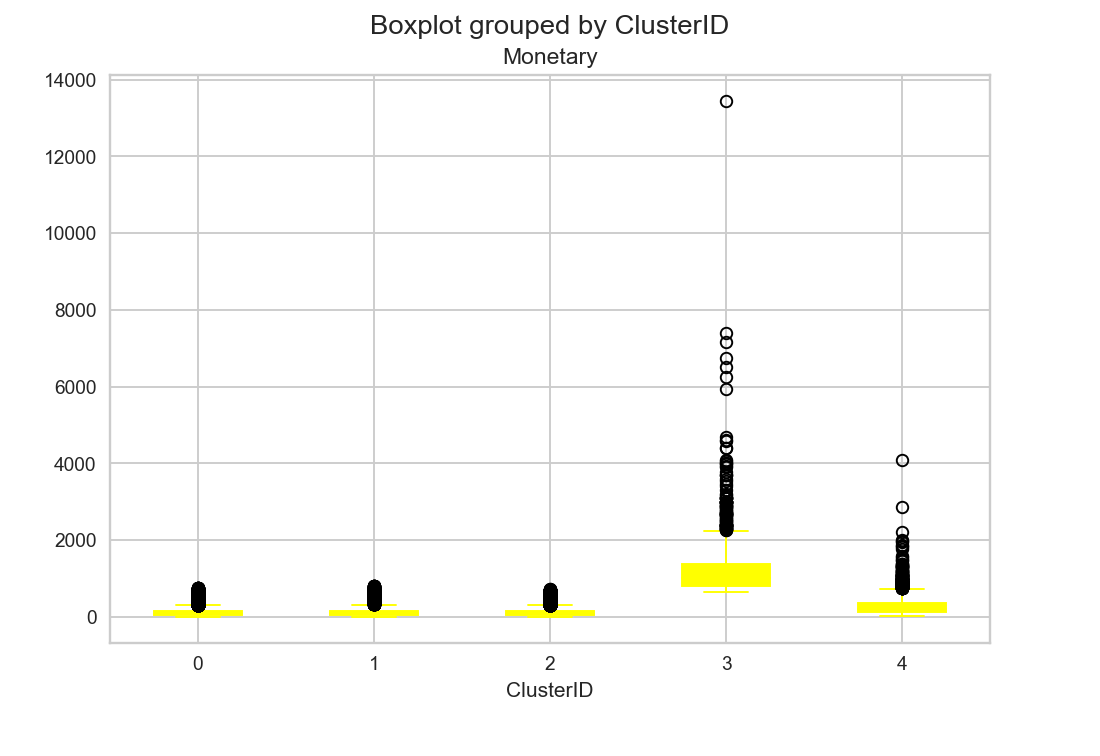

<AxesSubplot: title={'center': 'Monetary'}, xlabel='ClusterID'>

In [84]:
RFMS_km.boxplot(column='Monetary', by='ClusterID', color='yellow',patch_artist = True)

<IPython.core.display.Javascript object>


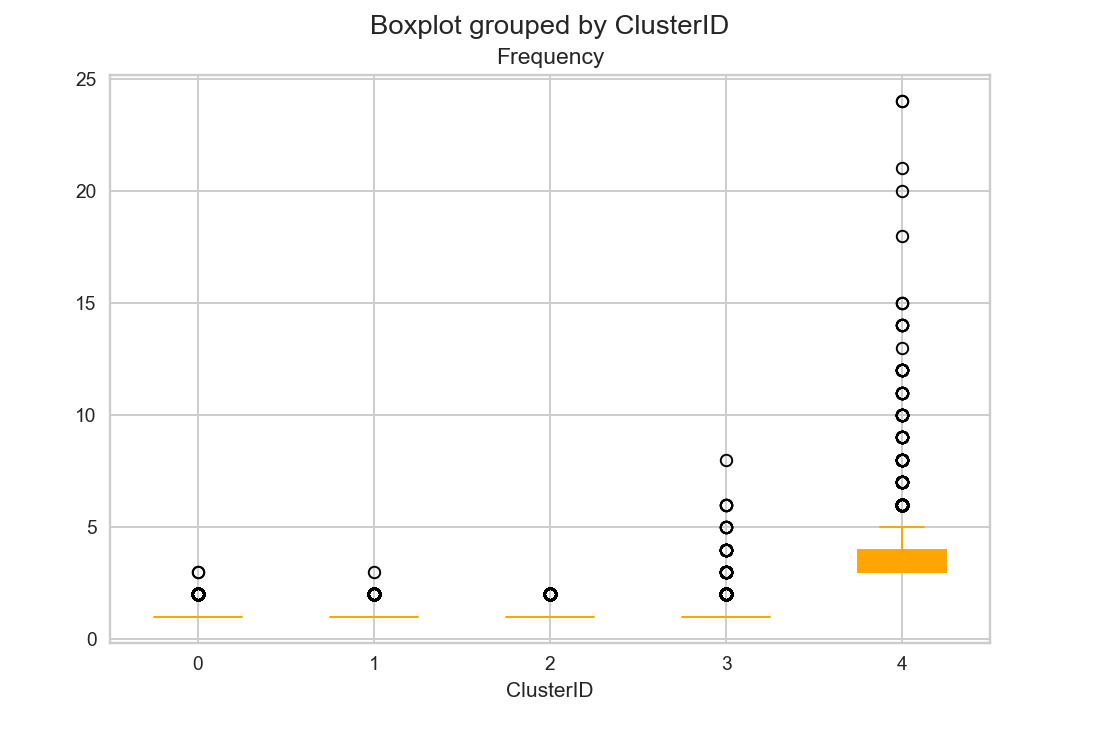

<AxesSubplot: title={'center': 'Frequency'}, xlabel='ClusterID'>

In [85]:
RFMS_km.boxplot(column='Frequency', by='ClusterID', color='orange',patch_artist = True)

**Observations**<br>
les clients du cluster 1 sont les plus mécontents

<IPython.core.display.Javascript object>


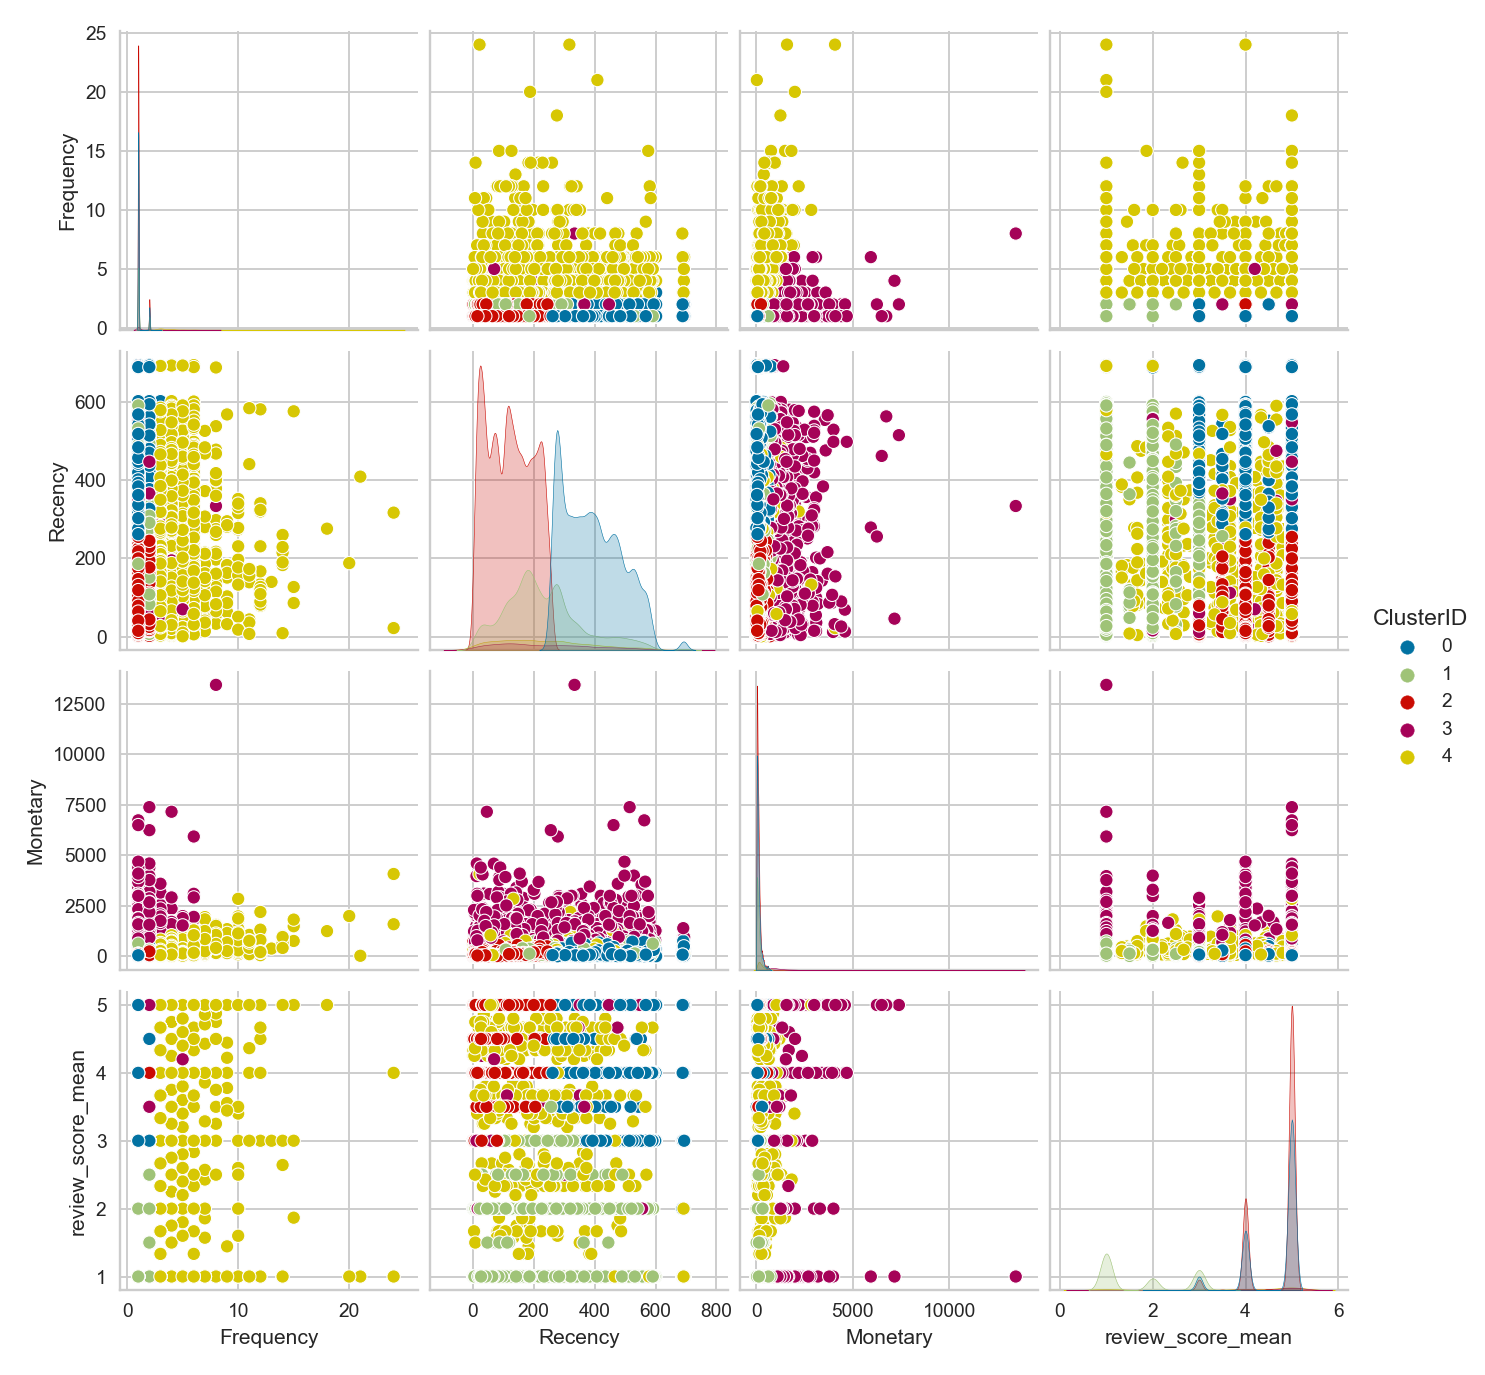

In [87]:
data1 = RFMS_km[['ClusterID', 'Frequency',  'Recency', 'Monetary','review_score_mean']]
sns.pairplot(data1, hue='ClusterID', 
             palette=sns.color_palette(n_colors=5))

<IPython.core.display.Javascript object>


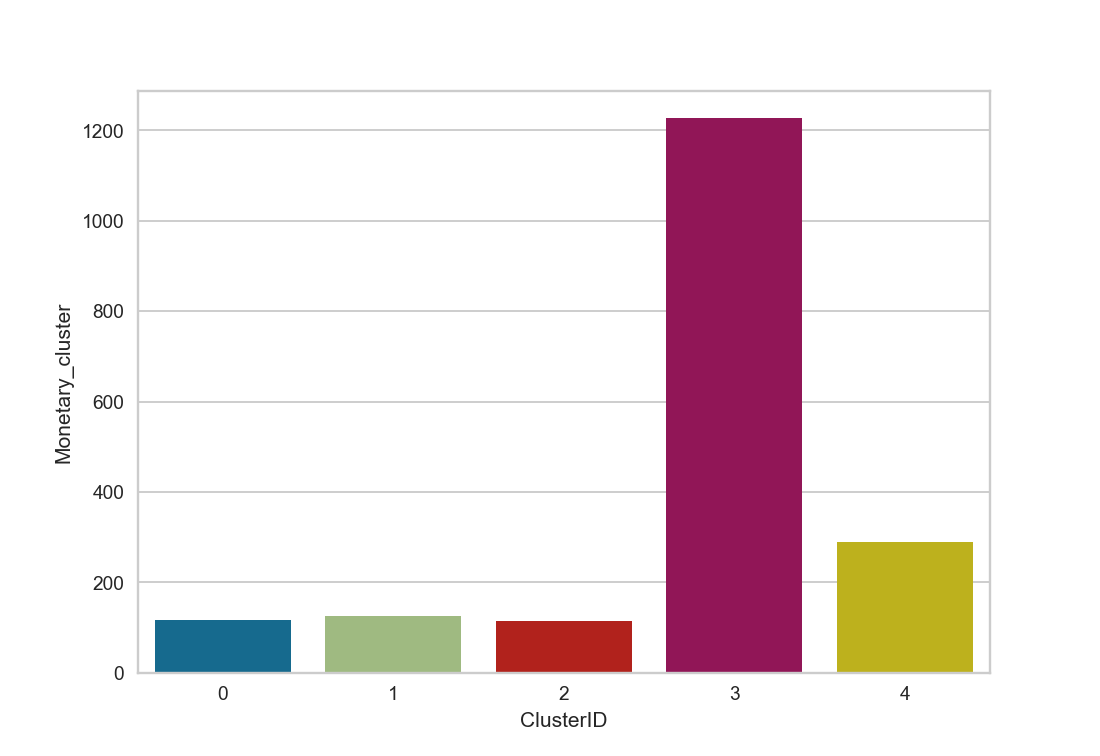

****************************************************************************************************


<IPython.core.display.Javascript object>


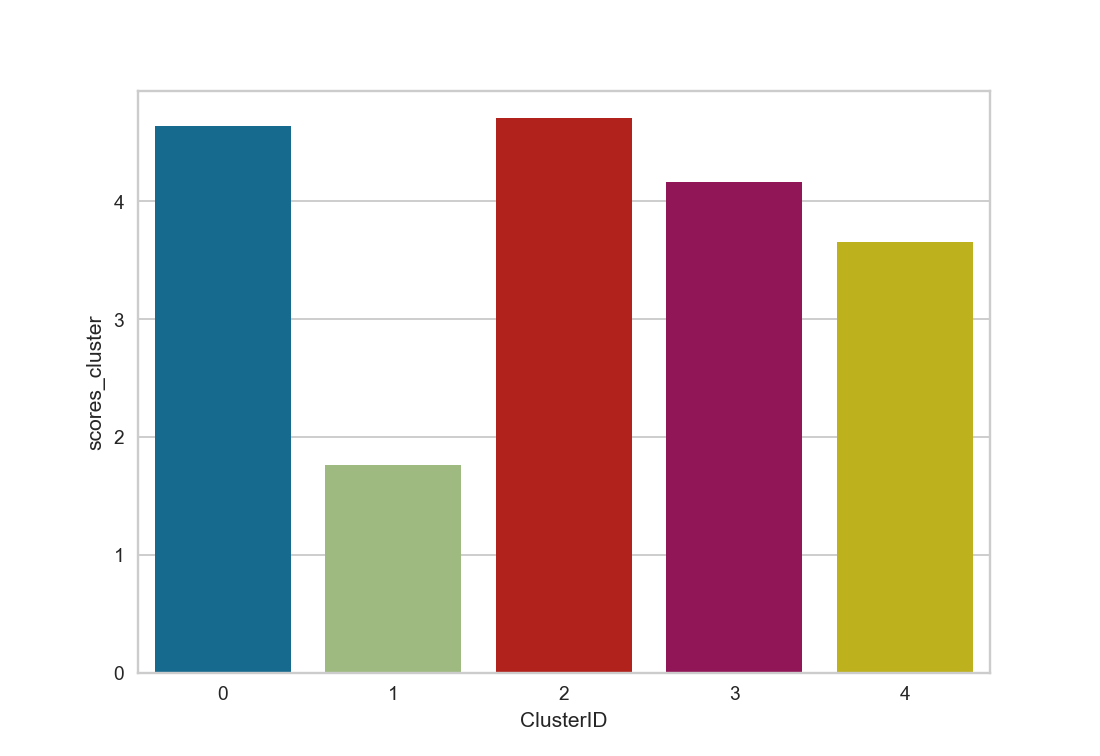

****************************************************************************************************


<IPython.core.display.Javascript object>


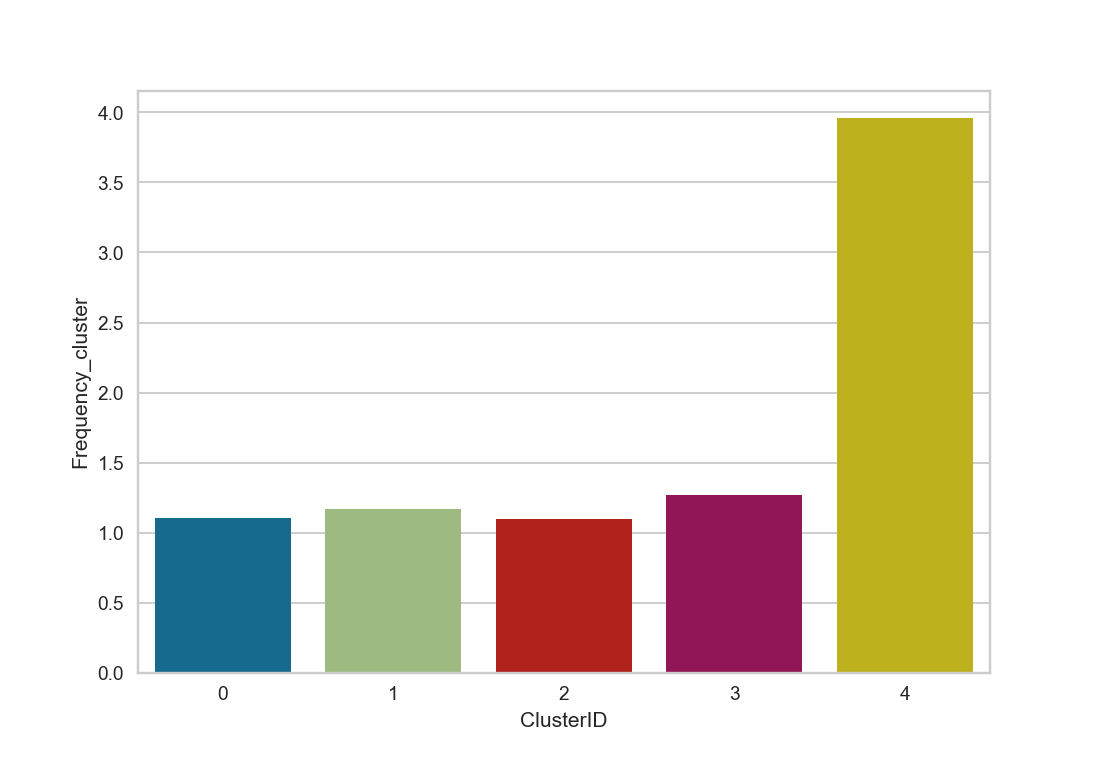

****************************************************************************************************


<IPython.core.display.Javascript object>


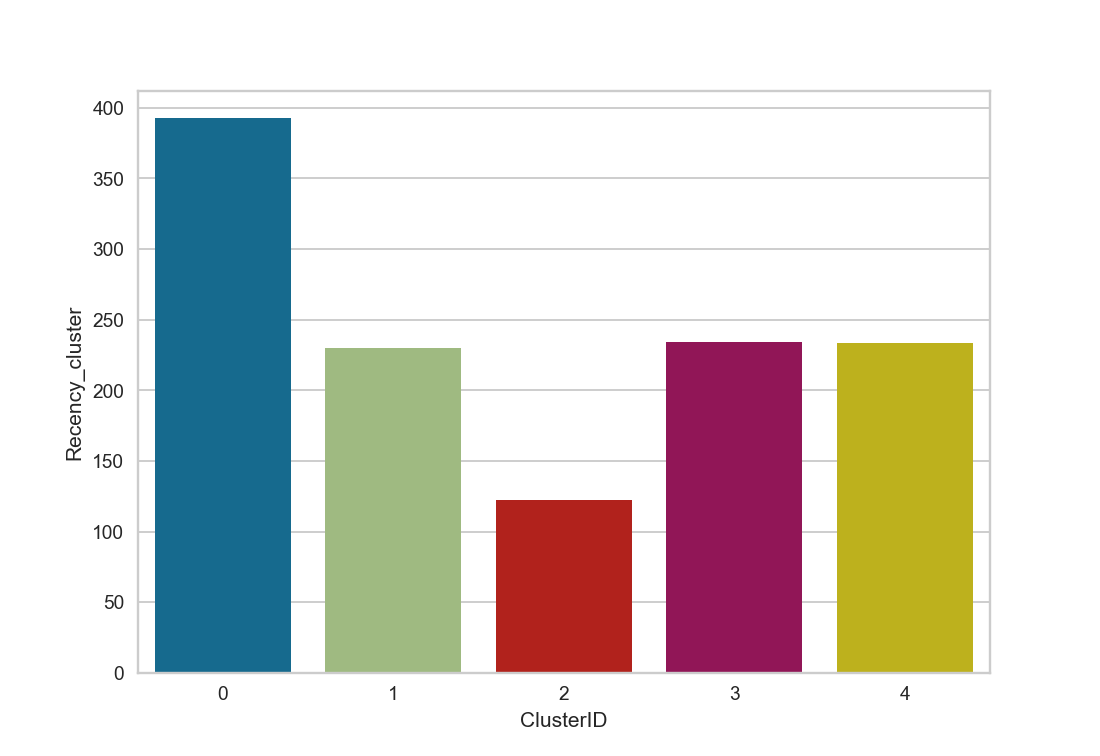

In [76]:
fig=plt.figure()
sns.barplot(x=df1.ClusterID, y=df1.Monetary_cluster)
plt.show()
print('*'*100)
fig=plt.figure()
sns.barplot(x=df1.ClusterID, y=df1.scores_cluster)
plt.show()
print('*'*100)
fig=plt.figure()
sns.barplot(x=df1.ClusterID, y=df1.Frequency_cluster)
plt.show()
print('*'*100)
fig=plt.figure()
sns.barplot(x=df1.ClusterID, y=df1.Recency_cluster)
plt.show()

**Observations**<br>
-cluster 0:les clients les plus anciens et les  satisfaits<br>
-cluster1:les clients sont les plus mécontents<br>
-cluster2:les clients les plus récents et  satisfaits <br>
-<b>cluster 3:<font color='red'>les clients avec les montants lesplus élevés, et satisfaits et anciens:poetntiel client</font>
    <br>
 -cluster4:anciens clients qui ont achetés fréquement et satisfaits

#### Caractérisation des clients (RFM+score)

In [77]:
customer_types2 = ['clients perdus', ' client mécontent',
                   ' nouveau client satisfait', 'potentiel client', 'client occasionnel']
rfm_score_caracte = ['clients  les plus anciens avec faible fréquence , faibles dépenses et satisfaits',
                     'clients anciens avec faibles fréquence et dépenses.pas satisfait',
                     'client les plus récents,et satisfaits ',
                     'client avec des dépenses importantes et satisfais et ça faits longtemps qu\'ils n\'ont pas commandés',
                     'clients anciens qui ont achetés fréquemment avec des montants bas et satistafits'
                     ]
d2 = {'Cluster': list(range(0, 5)), 'Type de client': customer_types2,
      'Caractéristiques RFM+score': rfm_score_caracte}

pd.set_option("display.max_colwidth", None,
              'display.colheader_justify', 'center')
res2 = pd.DataFrame(d2)
res2

,Cluster,Type de client,Caractéristiques RFM+score
0,0,clients perdus,"clients les plus anciens avec faible fréquence , faibles dépenses et satisfaits"
1,1,client mécontent,clients anciens avec faibles fréquence et dépenses.pas satisfait
2,2,nouveau client satisfait,"client les plus récents,et satisfaits"
3,3,potentiel client,client avec des dépenses importantes et satisfais et ça faits longtemps qu'ils n'ont pas commandés
4,4,client occasionnel,clients anciens qui ont achetés fréquemment avec des montants bas et satistafits


In [ ]:
df1.columns

### 3.3.DBSCAN (RFM)<a class="anchor" id="db"></a>

In [ ]:
from sklearn.neighbors import NearestNeighbors
%matplotlib notebook
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(Xstd)
distances, indices = neighbors_fit.kneighbors(Xstd)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.plot(distances)

In [88]:
Xstd_dbscan=Xstd.copy()

In [90]:

EPS = [0.2,0.35,0.45,0.55,0.65,0.75,0.9]
for e in EPS:
    db = DBSCAN(eps=e, min_samples=10).fit(Xstd_dbscan)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print(e)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("cutomers not associated to  clusters: %d" % n_noise_)
    print('*'*100)

0.2
Estimated number of clusters: 29
cutomers not associated to  clusters: 1768
****************************************************************************************************
0.35
Estimated number of clusters: 17
cutomers not associated to  clusters: 808
****************************************************************************************************
0.45
Estimated number of clusters: 11
cutomers not associated to  clusters: 586
****************************************************************************************************
0.55
Estimated number of clusters: 8
cutomers not associated to  clusters: 476
****************************************************************************************************
0.65
Estimated number of clusters: 8
cutomers not associated to  clusters: 375
****************************************************************************************************
0.75
Estimated number of clusters: 7
cutomers not associated to  clusters: 312
******************

In [94]:
start_db = time.time()
dbscan = DBSCAN(eps=0.65, min_samples=10).fit(Xstd_dbscan)
labels = dbscan.labels_
silh_sc = silhouette_score(Xstd_dbscan, labels)
print(f"DBSCAN Silhouette Coefficient :{silh_sc}")
elapsedtime_dbscan = time.time()-start_db
print(f"Dbscan elapsed time : {elapsedtime_dbscan}")
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(f"DBSCAN estimated number of clusters: {n_clusters_}" )
print(f"DBSCAN cutomers not associated to  clusters: {n_noise_}" )
pr_noise=100*n_noise_/Xstd_dbscan.shape[0]
print(f"% DBSCAN cutomers not associated to  clusters : {pr_noise}%" )
print('*'*100)

DBSCAN Silhouette Coefficient :0.3425731065771469
Dbscan elapsed time : 221.73725008964539
DBSCAN estimated number of clusters: 8
DBSCAN cutomers not associated to  clusters: 375
% DBSCAN cutomers not associated to  clusters : 0.4099346290911476%
****************************************************************************************************


In [93]:
Xstd_dbscan.shape

(91478, 3)

In [95]:
DBSCAN_clustered = Xstd_dbscan.copy()
DBSCAN_clustered.loc[:,'Cluster_dbscan'] = labels # append labels to points
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster_dbscan').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster_dbscan,
-1,375
0,78237
1,9943
2,790
3,1669
4,243
5,203
6,8
7,10


**Observations**<br>
avec 8 cluster il ya des clusters contenant peu de client.a rejeter ce choix d'eps


In [98]:
start_db2 = time.time()
dbscan2 = DBSCAN(eps=1, min_samples=10).fit(Xstd_dbscan)
labels2 = dbscan2.labels_


In [99]:
DBSCAN_clustered.loc[:,'Cluster_dbscan'] = labels2 # append labels to points
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster_dbscan').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster_dbscan,
-1,231
0,78257
1,9972
2,799
3,1679
4,30
5,269
6,224
7,17


In [ ]:
silh_sc2 = silhouette_score(Xstd_dbscan, labels2)
print(f"DBSCAN Silhouette Coefficient :{silh_sc2}")
elapsedtime_dbscan2 = time.time()-start_db2
print(f"Dbscan elapsed time : {elapsedtime_dbscan2}")
n_clusters2_ = len(set(labels2)) - (1 if -1 in labels2 else 0)
n_noise2_ = list(labels2).count(-1)
print(f"DBSCAN estimated number of clusters: {n_clusters2_}" )
print(f"DBSCAN cutomers not associated to  clusters: {n_noise2_}" )
pr_noise2=100*n_noise2_/Xstd_dbscan.shape[0]
print(f"% DBSCAN cutomers not associated to  clusters : {pr_noise2}%" )
print('*'*100)

**Observations**<br>
le dbscan n\'est pas adapté à ce type de probleme.<br>
le dbscan fonctionne par densité est dans notre cas la densite des 
3000 bons clients(qui ont commandés plusieurs fois est faible

### 3.4.Agglomerative clustering (RFM)<a class="anchor" id="ag"></a>

In [17]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [22]:
Xstd_agg=Xstd.sample(frac=0.6)

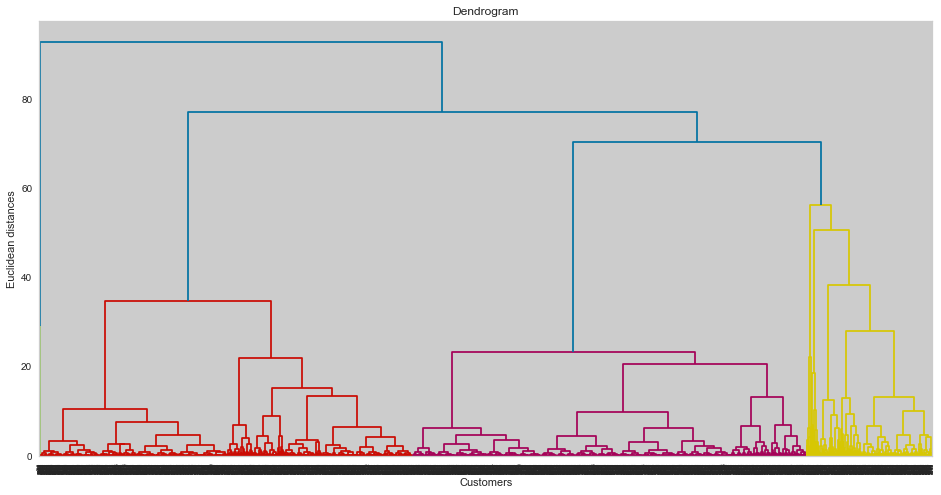

In [63]:
plt.figure(1, figsize = (16 ,8))
start_dendo = time.time()
dendrogram = sch.dendrogram(sch.linkage(Xstd_agg, method  = "ward"))
elapsed_time_dendo=time.time()-start_dendo
print(f"Dendogram elapsed time : {elapsed_time_dendo}")
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [23]:
Agg_clustered = Xstd_agg.copy()
start_agg=time.time()

aggclust = AgglomerativeClustering(n_clusters=6,affinity='euclidean', linkage='ward').fit(Xstd_agg)
clusters_agg=aggclust.labels_
Agg_clustered.loc[:,'Cluster_agg'] = clusters_agg
elapsed_agg=time.time()-start_agg
print(f"Agglomerative clustering elapsed time: {elapsed_agg}")
silh_agg = silhouette_score(Xstd_agg, clusters_agg)
print(f"Agglomerative clustering Silhouette Coefficient :{silh_agg}")

Agglomerative clustering elapsed time: 1028.4517543315887
Agglomerative clustering Silhouette Coefficient :0.3409504297220624


In [24]:
Agg_clust_sizes = Agg_clustered.groupby('Cluster_agg').size().to_frame()
Agg_clust_sizes.columns = ["Agg_size"]
Agg_clust_sizes

,Agg_size
Cluster_agg,
0,1849
1,1977
2,12944
3,21887
4,5803
5,10427


### 3.5.Clustering avec kprotype (RFM+favorite_purshase_month)<a class="anchor" id="kp"></a>

In [13]:
RFM_date.columns

Index(['customer_unique_id', 'Frequency', 'Recency', 'Monetary',
       'last_purshase_date', 'favorite_purshase_month'],
      dtype='object')

In [ ]:
customer_loc = customer_loc

In [100]:
RFM_month_scal = RFM_date.copy()
#RFM_month_scal = RFM_month_scal.sample(frac=0.1)
RFM_month_scal[['Frequency', 'Monetary', 'Recency']] = StandardScaler().fit_transform(
    RFM_month_scal[['Frequency', 'Monetary', 'Recency']])

X_sca = RFM_month_scal[['Frequency', 'Monetary',
                      'Recency', 'favorite_purshase_month']]


In [ ]:
costs=[]
for i in k_rng:
    print(i)
    try:
        kprototype = KPrototypes(n_jobs=-1, n_clusters=i, init='Huang', random_state=7,n_init=10, verbose=1)
        results_cluster=kprototype.fit_predict(X_sca, categorical=[3])
        costs.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(i))
    except:
        print(f"Can't cluster with {i} clusters")
        continue
plt.plot(k_rng, costs)
plt.xlabel('Number of clusters')
plt.ylabel('cost')

In [119]:

RFMM_kp = pd.concat([RFM_date, pd.Series(clusters)], axis=1)
#RFMM_kp = RFMM_kp[['customer_unique_id', 'Frequency',  'Recency',
 #                  'Monetary', 'favorite_purshase_month', 'ClusterID']]
RFMM_kp=RFMM_kp.rename(columns={0:'ClusterID'})
RFMM_kp = RFMM_kp[['customer_unique_id', 'Frequency',  'Recency',
                'Monetary', 'favorite_purshase_month', 'ClusterID']]
RFMM_kp

,customer_unique_id,Frequency,Recency,Monetary,favorite_purshase_month,ClusterID
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90,May,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90,May,1
2,0000f46a3911fa3c0805444483337064,1,537,69.00,March,2
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99,October,2
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00,November,2
...,...,...,...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,447,1570.00,June,0
91474,fffea47cd6d3cc0a88bd621562a9d061,1,262,64.89,December,2
91475,ffff371b4d645b6ecea244b27531430a,1,568,89.90,February,2
91476,ffff5962728ec6157033ef9805bacc48,1,119,115.00,May,1


In [120]:
kp1_recency_clusters = mean_clus_feat(RFMM_kp, 'ClusterID', 'Recency')
kp1_frequency_clusters = mean_clus_feat(RFMM_kp, 'ClusterID', 'Frequency')
kp1_monetary_clusters = mean_clus_feat(RFMM_kp, 'ClusterID', 'Monetary')


In [123]:
kp1_monetary_clusters

,Monetary_mean
ClusterID,
0,1179.952849
1,114.814737
2,115.876227
3,289.112522


In [122]:
kp1_frequency_clusters

,Frequency_mean
ClusterID,
0,1.263930
1,1.111214
2,1.113570
3,3.958239


In [121]:
kp1_recency_clusters

,Recency_mean
ClusterID,
0,236.162757
1,126.978450
2,386.351231
3,233.444480


In [125]:
RFMM_kp.columns

Index(['customer_unique_id', 'Frequency', 'Recency', 'Monetary',
       'favorite_purshase_month', 'ClusterID'],
      dtype='object')

In [ ]:


I like using seaborn for this kind of visualizations. I guessthe "extra level" you mean is called "hue".

import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x="day", y="total_bill", hue="smoker",              
data=tips, palette="Set3")

In [127]:
RFMM_kp.boxplot(column='Recency', hue='ClusterID', by='favorite_purshase_month',color='red',patch_artist = True)

ValueError: Cannot use `hue` without `x` and `y`

## 4.Contrat de maintenance<a class="anchor" id="st"></a>

In [3]:
RFM_date.columns

Index(['customer_unique_id', 'Frequency', 'Recency', 'Monetary',
       'last_purshase_date'],
      dtype='object')

In [11]:
RFM_date['last_purshase_date'] = pd.to_datetime(RFM_date['last_purshase_date'])

In [14]:
period_days_dataset = RFM_date['last_purshase_date'].max(
)-RFM_date['last_purshase_date'].min()
print(
    f"La période complète des commandes porte sur {period_days_dataset} jours")
period_months_dataset = round(period_days_dataset / np.timedelta64(1, 'M'))
print("La période complète des commandes porte sur {} mois.".format(
    period_months_dataset))

La période complète des commandes porte sur 694 days 22:03:47 jours
La période complète des commandes porte sur 23 mois.


In [15]:
def fmake_data(dm, period, initial=False):
    '''
    initial:boolean
            indique si  le datset est l'initial
    period:int
           indique la période d'incrémentation en mois après le dataset initial
    dm:string
       indique si on va prendre la période en jours ou mois .Il prend deux valeurs:day,month()

    '''
    RFM_date['last_purshase_date'] = pd.to_datetime(
        RFM_date.last_purshase_date)
    if dm == 'day':
        if initial == True:
            period = 365  # 12mois=365jours
        else:
            period = 365+period
        stop = RFM_date.last_purshase_date.min()+pd.DateOffset(days=int(period))
    elif dm == 'month':
        if initial == True:
            period = 12  # 12mois
        else:
            period = 12+period
        stop = RFM_date.last_purshase_date.min()+pd.DateOffset(months=int(period))

    start = RFM_date.last_purshase_date.min()
    # stop=RFM_date.last_purshase_date.min()+pd.DateOffset(days=int(period))
    # stop=start+pd.DateOffset(days=int(period))
    print('Début de la période:', start)
    print('Fin de la période:', stop)
    data = RFM_date[(RFM_date['last_purshase_date'] >= start)
                    & (RFM_date['last_purshase_date'] < stop)]

    print('shape', data.shape)
    print(50*'-')
    return (data)

In [16]:
def compute_ari_score(rang, dm, data_init, k, init_labels):
    ari_score = []
    for p in rang:
        # Create dataset for period
        print(p)
        data_period = fmake_data(dm, period=p, initial=False)
        data_period = data_period[['Frequency', 'Recency', 'Monetary']]
        # K-Means
        kmeans_p = Pipeline([("preprocessor", StandardScaler()),
                             ("kmeans", KMeans(k))])
        kmeans_p.fit(data_period)
        p_labels = kmeans_p.named_steps['kmeans'].labels_
        # Filter on initial customer client
        list_init = data_init.index
        mask = data_period.index.isin(list_init)
        clusters_new = kmeans_p.named_steps['kmeans'].labels_[mask]
        print(len(clusters_new))
        print(mask)
        print('init label', init_labels)
        print('predicted label', p_labels)
        # Calculate ARI score
        ari_p = adjusted_rand_score(init_labels, clusters_new)
        print(ari_p)
        ari_score.append([p, ari_p])
    return (ari_score)

In [17]:
def plot_ari_score(ari_score, xlabe, rg):
    %matplotlib notebook
    ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

    # plot ARI Score
    fig = plt.figure(figsize=(12, 8))
    sns.lineplot(data=ari_score, x="periode", y="ARI")
    plt.xticks(rg)
    plt.xlabel(xlabe)
    plt.ylabel("Score ARI")

    plt.title("Stabilité temporelle de la segmentation par K-Means",
              fontsize=18,
              color="b")
    plt.show()

#### Période en jours

In [19]:
data_ini_d = fmake_data('day', period=15, initial=True)
data_init_d = data_ini_d[['Frequency', 'Recency', 'Monetary']]

kmeans_init_d = Pipeline([("preprocessor", StandardScaler()),
                          ("kmeans", KMeans(4))])
kmeans_init_d.fit(data_init_d)
init_labels_d = kmeans_init_d.named_steps['kmeans'].labels_

Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-03 16:56:50
shape (24798, 5)
--------------------------------------------------


In [35]:
nb_days = round(period_days_dataset / np.timedelta64(1, 'D'))
step_days = 7
range_days = np.arange(0, (nb_days-365), step_days)
ari_score1 = compute_ari_score(
    range_days, 'day', data_init_d, 4, init_labels_d)

0
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-03 16:56:50
shape (24798, 5)
--------------------------------------------------
24798
[ True  True  True ...  True  True  True]
init label [1 1 0 ... 2 1 1]
predicted label [2 2 0 ... 1 2 2]
0.9991488654196955
7
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-10 16:56:50
shape (25732, 5)
--------------------------------------------------
24798
[ True  True  True ...  True  True  True]
init label [1 1 0 ... 2 1 1]
predicted label [1 1 3 ... 0 1 1]
0.9167089417013028
14
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-17 16:56:50
shape (26721, 5)
--------------------------------------------------
24798
[ True False  True ...  True  True  True]
init label [1 1 0 ... 2 1 1]
predicted label [0 3 0 ... 2 0 0]
0.8629079816097713
21
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-24 16:56:50
shape (27716, 5)
--------------------------------------------------
24798
[ 

24798
[ True False False ... False  True  True]
init label [1 1 0 ... 2 1 1]
predicted label [0 1 1 ... 1 0 0]
0.155366696741439
210
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2018-05-01 16:56:50
shape (66815, 5)
--------------------------------------------------
24798
[ True False False ... False  True  True]
init label [1 1 0 ... 2 1 1]
predicted label [1 0 0 ... 0 1 1]
0.16384945851141486
217
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2018-05-08 16:56:50
shape (68668, 5)
--------------------------------------------------
24798
[False  True False ...  True False  True]
init label [1 1 0 ... 2 1 1]
predicted label [0 1 0 ... 1 0 1]
0.16878310631857812
224
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2018-05-15 16:56:50
shape (70584, 5)
--------------------------------------------------
24798
[False False  True ...  True False  True]
init label [1 1 0 ... 2 1 1]
predicted label [3 3 2 ... 2 3 2]
0.16876205505090452
231
Début de la périod

<IPython.core.display.Javascript object>


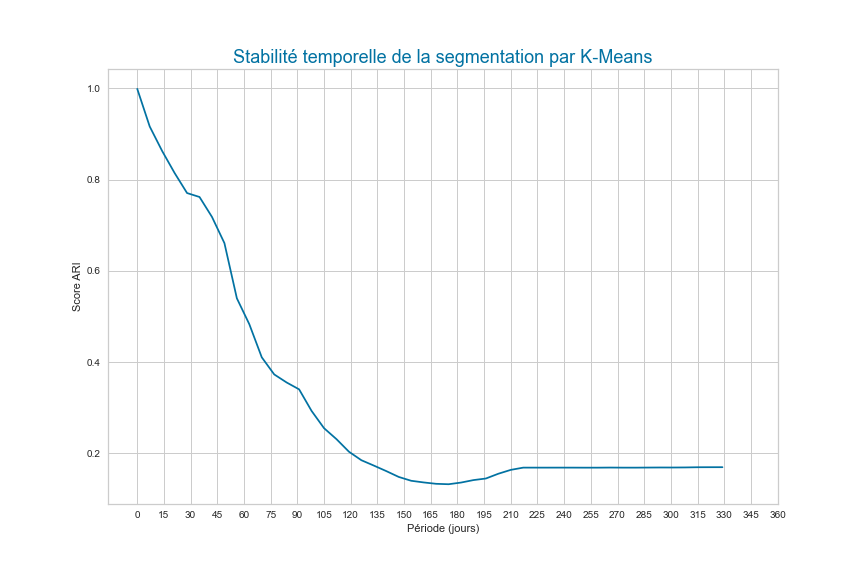

In [37]:
plot_ari_score(ari_score1, "Période (jours)", np.arange(0, 365, step=15))

#### Période en mois

In [23]:
data_init_m = fmake_data('month', period=15, initial=True)
data_init_m = data_init_m[['Frequency', 'Recency', 'Monetary']]

kmeans_init_m = Pipeline([("preprocessor", StandardScaler()),
                          ("kmeans", KMeans(4))])
kmeans_init_m.fit(data_init_m)
init_labels_m = kmeans_init_m.named_steps['kmeans'].labels_

Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-03 16:56:50
shape (24798, 5)
--------------------------------------------------


In [30]:
pas = 1
range_months = np.arange(0, (period_months_dataset-12), pas)

In [31]:
ari_score2 = compute_ari_score(
    range_months, 'month', data_init_m, 4, init_labels_m)

0
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-03 16:56:50
shape (24798, 5)
--------------------------------------------------
24798
[ True  True  True ...  True  True  True]
init label [0 0 1 ... 3 0 0]
predicted label [2 2 1 ... 3 2 2]
1.0
1
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-11-03 16:56:50
shape (28956, 5)
--------------------------------------------------
24798
[ True False  True ...  True  True  True]
init label [0 0 1 ... 3 0 0]
predicted label [1 0 1 ... 3 1 1]
0.7675768710226032
2
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-12-03 16:56:50
shape (36096, 5)
--------------------------------------------------
24798
[ True False False ...  True  True  True]
init label [0 0 1 ... 3 0 0]
predicted label [1 2 2 ... 0 1 1]
0.4901000189397328
3
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2018-01-03 16:56:50
shape (41089, 5)
--------------------------------------------------
24798
[ True False False 

<IPython.core.display.Javascript object>


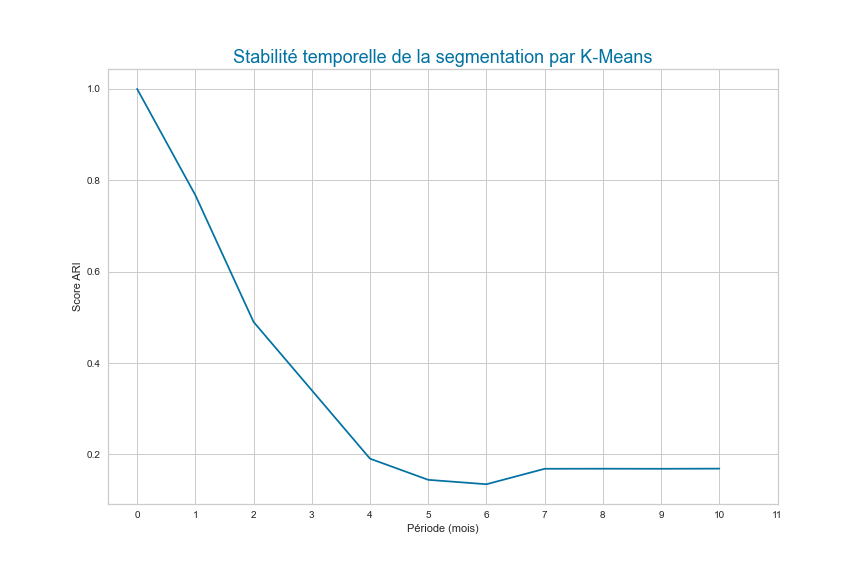

In [38]:
plot_ari_score(ari_score2, "Période (mois)", np.arange(0, 12, step=1))